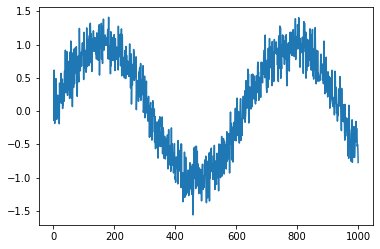

In [3]:
import torch
from matplotlib import pyplot as plt


T = 1000    # 产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.plot(time, x)
plt.show()

In [4]:
import sys
sys.path.append('..')
import helper

tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:,i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_trains = 16, 600

train_iter = helper.Loader.load_array((features[:n_trains], labels[:n_trains]), batch_size, True)

In [5]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
def get_net():
    net =torch.nn.Sequential(
        torch.nn.Linear(4, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net
loss = torch.nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {helper.Evaluater.loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.083249
epoch 2, loss: 0.064525
epoch 3, loss: 0.062096
epoch 4, loss: 0.061875
epoch 5, loss: 0.055758


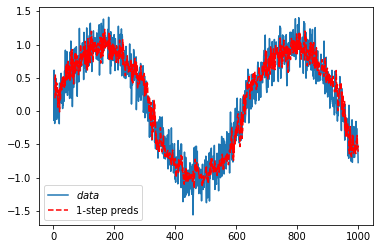

In [13]:
onestep_preds = net(features)
plt.plot(time, x, label = '$data$')
plt.plot(time[tau:], onestep_preds.detach().numpy(), ls='--', color = 'r', label = '1-step preds')
plt.legend()
plt.show()

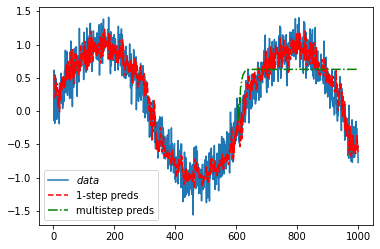

In [20]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_trains + tau] = x[:n_trains + tau]
for i in range(n_trains + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1, -1)))
plt.plot(time, x, label = '$data$')
plt.plot(time[tau:], onestep_preds.detach().numpy(), ls='--', color = 'r', label = '1-step preds')
plt.plot(time[n_trains + tau:], multistep_preds[n_trains + tau:].detach().numpy(), 
            ls = '-.', label = 'multistep preds', color = 'green')
plt.legend()
plt.show()

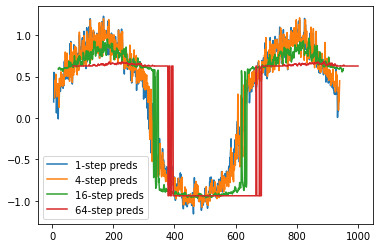

In [22]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)

for i in steps:
    plt.plot(time[tau + i - 1: T - max_steps + i], features[:, (tau + i - 1)].detach().numpy(),
                label = f'{i}-step preds')
plt.legend()
plt.show()